# Requirement 5

We first define the environment used in our simulations.  
The **`PricingEnvConversion`** class models a dynamic pricing scenario with multiple stationary intervals (epochs).  
In each round, the agent chooses a price for each product, customers decide to purchase according to the given conversion probabilities, and the environment returns the corresponding demand and profit.

In [9]:
import numpy as np


class PricingEnvConversion:
    def __init__(self, intervals, B, T, n_customers=100):
        """
        Initialize pricing environment with multiple stationary intervals.

        Args:
            intervals (list of dict): Each interval defines:
                - 'start' (int): starting round index (inclusive)
                - 'end' (int): ending round index (exclusive)
                - 'mu' (ndarray): N x P profit matrix for that interval
                - 'conversion_fn' (callable): maps price_idx -> purchase probability
            B (int): total cumulative inventory across all rounds
            T (int): total number of rounds in the horizon
            n_customers (int): number of potential buyers per round
        """
        self.intervals = intervals
        self.T = T
        self.n_customers = n_customers
        self.t = 0
        self.N, self.P = intervals[0]['mu'].shape
        self._set_interval(0)

    def _set_interval(self, idx):
        """
        Switch environment to a given interval.

        Args:
            idx (int): index of the interval in self.intervals
        """
        self.current_interval = idx
        self.mu = self.intervals[idx]['mu']
        self.conversion_fn = self.intervals[idx]['conversion_fn']

    def round(self, price_vector):
        """
        Simulate one round of selling given chosen prices.

        Args:
            price_vector (list of int): chosen price index per product,
                                        -1 means product is not offered

        Returns:
            demand (ndarray): units sold per product
            profit (ndarray): total reward per product
        """
        if self.t >= self.T:
            raise Exception("Environment finished all rounds.")

        # Check if interval should change
        if self.current_interval < len(self.intervals) - 1:
            if self.t >= self.intervals[self.current_interval]['end']:
                self._set_interval(self.current_interval + 1)

        rewards_per_unit = np.zeros(self.N)
        demand = np.zeros(self.N, dtype=int)
        profit = np.zeros(self.N)

        for i in range(self.N):
            price_idx = price_vector[i]
            if price_idx == -1:
                continue
            rewards_per_unit[i] = self.mu[i, price_idx]
            prob = self.conversion_fn(price_idx)
            demand[i] = np.random.binomial(self.n_customers, prob)
            profit[i] = rewards_per_unit[i] * demand[i]

        self.t += 1
        return demand, profit


### Combinatorial UCB Agent

This class implements a **sliding-window UCB algorithm** for dynamic pricing with inventory limits.  
It updates reward and consumption estimates from recent rounds, applies UCB/LCB bounds, solves a linear program to respect constraints, and samples feasible prices for each product.

In [10]:
from collections import deque
import numpy as np
from scipy import optimize

class CombinatorialUCB:
    def __init__(self, N, P, B, T, window_size=100):
        """
        Initialize the UCB-based pricing agent.
        N: number of products
        P: number of prices per product
        B: total inventory capacity shared across products
        T: total number of rounds
        window_size: number of past rounds to keep in the sliding window
        """
        self.N = N
        self.P = P
        self.B = B
        self.T = T
        self.window_size = window_size
        self.reset()

    def reset(self):
        """
        Reset agent state for a new run.
        Resets inventory, time, and clears the sliding-window buffers.
        """
        self.remaining_inventory = self.B
        self.t = 0
        self.rewards_window = deque(maxlen=self.window_size)       # past per-product rewards
        self.consumptions_window = deque(maxlen=self.window_size)  # past per-product consumptions

    def pull_arm(self):
        """
        Choose a price for each product using UCB.
        Returns:
            list of chosen price indices per product (-1 if not sold)
        """
        if self.remaining_inventory < 1:
            return [-1] * self.N

        # Compute empirical means and consumptions from sliding window
        if len(self.rewards_window) == 0:
            means = np.zeros((self.N, self.P))
            avg_c = np.zeros((self.N, self.P))
            counts = np.zeros((self.N, self.P))
        else:
            rewards_stack = np.stack(self.rewards_window, axis=0)       # shape: window_size x N x P
            consumptions_stack = np.stack(self.consumptions_window, axis=0)
            counts = np.sum(rewards_stack != 0, axis=0)
            means = np.sum(rewards_stack, axis=0) / np.maximum(1, counts)
            avg_c = np.sum(consumptions_stack, axis=0) / np.maximum(1, counts)

        # Initial forced exploration
        if self.t < self.P:
            return [self.t % self.P for _ in range(self.N)]

        # UCB for rewards and LCB for costs
        f_ucbs = means + np.sqrt(2*np.log(self.t) / (counts + 1e-6))
        c_lcbs = avg_c - np.sqrt(2*np.log(self.t) / (counts + 1e-6))

        rho = self.remaining_inventory / max(1, self.T - self.t)

        # Solve LP to compute price distribution
        gamma = self.compute_opt(f_ucbs, c_lcbs, rho)

        prices = []
        for i in range(self.N):
            probs = np.clip(gamma[i], 0, None)
            probs /= probs.sum() + 1e-8
            choice = np.random.choice(len(probs), p=probs)
            prices.append(-1 if choice == 0 else choice - 1)

        return prices

    def compute_opt(self, f_ucbs, c_lcbs, rho):
        """
        Solve linear program to obtain price distribution.
        Arguments:
            f_ucbs: optimistic reward estimates (N x P matrix)
            c_lcbs: conservative cost estimates (N x P matrix)
            rho: target average consumption per round
        Returns:
            gamma: N x (P+1) matrix of price probabilities (includes no-sale option)
        """
        N, P = self.N, self.P
        f_ucbs = np.hstack([np.zeros((N,1)), f_ucbs])
        c_lcbs = np.hstack([np.zeros((N,1)), c_lcbs])
        c_obj = -f_ucbs.flatten()
        bounds = [(0,1) for _ in range(N*(P+1))]

        # Equality: each product’s probabilities sum to 1
        A_eq = np.zeros((N, N*(P+1)))
        b_eq = np.ones(N)
        for i in range(N):
            for j in range(P+1):
                A_eq[i, i*(P+1)+j] = 1

        # Inequality: expected consumption <= rho
        A_ub = [c_lcbs.flatten()]
        b_ub = [rho]

        res = optimize.linprog(c=c_obj, A_ub=A_ub, b_ub=b_ub, A_eq=A_eq, b_eq=b_eq, bounds=bounds)
        if res.success:
            return res.x.reshape(N, P+1)
        else:
            return np.zeros((N, P+1))

    def update(self, prices, demand, rewards):
        """
        Update sliding-window statistics with observed outcomes.
        Arguments:
            prices: list of chosen price indices per product (-1 if not sold)
            demand: observed demand per product
            rewards: observed reward per product
        """
        self.t += 1
        self.remaining_inventory = max(0, self.remaining_inventory - sum(demand))

        rewards_mat = np.zeros((self.N, self.P))
        consumption_mat = np.zeros((self.N, self.P))
        for i in range(self.N):
            p = prices[i]
            if p != -1:
                rewards_mat[i,p] = rewards[i]
                consumption_mat[i,p] = demand[i]

        self.rewards_window.append(rewards_mat)
        self.consumptions_window.append(consumption_mat)


This function samples a single action from the LP-computed probability distribution (`gamma`) for each product, returning both the chosen prices and the corresponding expected reward.

In [11]:
def clairvoyant_sample_action(gamma, f):
    """
    gamma: N x (P+1) array of action probabilities from the LP 
           (first column = "do not sell" option).
    f: N x P array of true expected rewards for each product/price pair.

    Returns:
        sampled_action: list of chosen price indices per product 
                        (-1 = "do not sell").
        expected_reward_per_round: total expected reward across products 
                                   for the sampled action.
    """
    N, _ = gamma.shape

    sampled_action = []
    expected_reward_per_round = 0.0
    for i in range(N):
        probs = np.clip(gamma[i], 0, None)
        if probs.sum() > 0:
            probs /= probs.sum()
        else:
            probs = np.zeros_like(probs)
            probs[0] = 1  # fallback: "do not sell"
        idx = np.random.choice(len(probs), p=probs)
        if idx == 0:
            sampled_action.append(-1)
        else:
            sampled_action.append(idx-1)
            expected_reward_per_round += f[i, idx-1]

    return sampled_action, expected_reward_per_round


This code defines the `DualAgent` class, which implements a primal-dual online learning agent for combinatorial pricing under inventory constraints. It uses a sliding window to estimate empirical rewards and consumptions, computes an optimal action distribution via a linear program, and updates a dual variable to respect capacity limits.


In [12]:
from collections import deque
import numpy as np
from scipy import optimize

class DualAgent:
    def __init__(self, N, P, B, T, window_size=100):
        """
        N: number of products
        P: number of prices
        B: shared capacity (total inventory)
        T: total number of rounds
        window_size: number of past rounds to keep in the sliding window
        """
        self.N = N
        self.P = P
        self.B = B
        self.T = T
        self.window_size = window_size

        self.lambda_ = 0

        self.reset()

    def reset(self):
        """Reset agent state for a new simulation
        
        Resets remaining inventory, time step, sliding windows for rewards
        and consumptions, and dual variable lambda.
        """
        self.remaining_inventory = self.B
        self.t = 0
        self.rewards_window = deque(maxlen=self.window_size)       
        self.consumptions_window = deque(maxlen=self.window_size)  
        self.lambda_ = 0

    def pull_arm(self):
        """Pull arm using primal-dual approach with sliding window statistics.
        
        Returns:
            prices : list of int
                Selected price index for each product (-1 = not offered)
        """
        if self.remaining_inventory < 1:
            return [-1] * self.N

        # Compute empirical means and average consumptions from sliding window
        if len(self.rewards_window) == 0:
            means = np.zeros((self.N, self.P))
            avg_c = np.zeros((self.N, self.P))
            counts = np.zeros((self.N, self.P))
        else:
            rewards_stack = np.stack(self.rewards_window, axis=0)
            consumptions_stack = np.stack(self.consumptions_window, axis=0)
            counts = np.sum(rewards_stack != 0, axis=0)
            means = np.sum(rewards_stack, axis=0) / np.maximum(1, counts)
            avg_c = np.sum(consumptions_stack, axis=0) / np.maximum(1, counts)

            """
            init_reward = np.max(means) * 10
            init_cost = np.max(avg_c) * 0.1

            means = np.where(counts == 0, init_reward,
                np.sum(rewards_stack, axis=0) / np.maximum(1, counts))

            avg_c = np.where(counts == 0, init_cost,
                np.sum(consumptions_stack, axis=0) / np.maximum(1, counts))
            """


        # Initial exploration
        if self.t < self.P:
            return [self.t % self.P for _ in range(self.N)]

        # Primal-dual step
        gamma = self.compute_opt(means, avg_c, self.lambda_)

        # Sample prices for each product from computed distribution
        prices = []
        for i in range(self.N):
            probs = np.clip(gamma[i], 0, None)
            probs /= probs.sum() + 1e-8
            choice = np.random.choice(len(probs), p=probs)
            prices.append(-1 if choice == 0 else choice - 1)
        return prices
        
    def compute_opt(self, f_means, c_means, lambda_):
        """Compute optimal product/price distribution under primal-dual Lagrangian.
        
        Parameters:
            f_means : np.ndarray, shape (N, P)
                Empirical mean rewards for each product i and price option j
            c_means : np.ndarray, shape (N, P)
                Empirical mean consumptions (units) for each product i and price option j
            lambda_ : float
                Current dual variable λ (shadow price of capacity)
        
        Returns:
            policy : np.ndarray, shape (N, P+1)
                Probability distribution over actions for each product (column 0 = "not offer")
        """
        N, P = self.N, self.P
        f_means = np.hstack([np.zeros((N, 1)), f_means])
        c_means = np.hstack([np.zeros((N, 1)), c_means])
        obj = (f_means - lambda_ * c_means).flatten()

        A_eq = np.zeros((N, N * (P + 1)))
        b_eq = np.ones(N)
        for i in range(N):
            for j in range(P + 1):
                A_eq[i, i * (P + 1) + j] = 1

        bounds = [(0, 1) for _ in range(N * (P + 1))]
        res = optimize.linprog(c=-obj, A_eq=A_eq, b_eq=b_eq, bounds=bounds, method="highs")
        if res.success:
            return res.x.reshape(N, P + 1)
        else:
            return np.ones((N, P + 1)) / (P + 1)
        
    def update(self, prices, demand, rewards):
        """Update sliding-window estimates and dual variable with observed data.
        
        Arguments:
            prices: list of chosen price indices per product (-1 if product not offered)
            demand: observed demand per product
            rewards: observed per-product reward
        """
        self.t += 1
        total_consumed = sum(demand)
        self.remaining_inventory = max(0, self.remaining_inventory - total_consumed)

        rewards_mat = np.zeros((self.N, self.P))
        consumption_mat = np.zeros((self.N, self.P))
        for i in range(self.N):
            p = prices[i]
            if p != -1:
                rewards_mat[i, p] = rewards[i]
                consumption_mat[i, p] = demand[i]

        self.rewards_window.append(rewards_mat)
        self.consumptions_window.append(consumption_mat)

        rho = self.remaining_inventory / max(1, self.T - self.t)
        eta = 0.005 / self.N
        self.lambda_ = max(0, self.lambda_ + eta * (total_consumed - rho))

In this simulation, we compare the performance of the `DualAgent` against a clairvoyant benchmark across three distinct stationary epochs. Each epoch has a fixed expected reward matrix and a price-to-conversion function, while the agent adapts using a sliding-window primal-dual approach. The simulation runs multiple seeds to account for stochasticity in customer demand and action sampling. 

At the end, we plot the **regret ratio over rounds**, which measures how far the agent's cumulative reward is from the clairvoyant's cumulative reward, normalized by the number of rounds. Red dashed vertical lines indicate the transitions between epochs, helping to visualize how the agent adapts to changes in the environment.


In [13]:
import numpy as np
import matplotlib.pyplot as plt
from collections import deque

# Example conversion functions
def conv_fn_1(price_idx):
    return 0.1 * (price_idx + 1)

def conv_fn_2(price_idx):
    return 0.5 - 0.1 * price_idx

def conv_fn_3(price_idx):
    return 0.2 + 0.05 * price_idx


# Example mu matrices
mu1 = np.array([[1, 2, 3],
                [2, 4, 6]])
mu2 = np.array([[3, 2, 1],
                [6, 4, 2]])
mu3 = np.array([[2, 3, 4],
                [3, 6, 9]])


# Define intervals (3 epochs in this case)
l = 5000

intervals = [
    {'start': 0, 'end': l*0.5, 'mu': mu1, 'conversion_fn': conv_fn_1},
    {'start': l*0.5, 'end': l*1.5, 'mu': mu2, 'conversion_fn': conv_fn_2},
    {'start': l*1.5, 'end': l*3, 'mu': mu3, 'conversion_fn': conv_fn_3}
]

# Simulation parameters
N, P = intervals[0]['mu'].shape
n_customers = 10

T_total = l*3
#window_size = round(0.35 * l)
window_size = l*9
#n_runs = 8
n_runs = 2
checkpoint_interval = 1000  # print checkpoint every 1000 rounds
B = round(T_total * n_customers * N * 0.25)

# Run simulations
all_regret_ratios = []
final_regret_ratios = []

env = PricingEnvConversion(intervals=intervals, B=B, T=T_total, n_customers=n_customers)
agent_clar = CombinatorialUCB(N=N, P=P, B=B, T=T_total, window_size=window_size)

agent = DualAgent(N=N, P=P, B=B, T=T_total, window_size=window_size)

clairvoyant_solutions = []

rho_clar = B / T_total

for interval in intervals:
    mu = np.array(interval['mu'])
    conversion_fn = interval['conversion_fn']

    # f: expected reward per product/price
    f = mu * np.array([conversion_fn(p) for p in range(P)]) * n_customers

    # c: expected cost per product/price
    c = np.array([[conversion_fn(p) for p in range(P)] for _ in range(N)]) * n_customers

    gamma_clar = agent_clar.compute_opt(f, c, rho_clar)

    clairvoyant_solutions.append({
        "start": interval['start'],
        "end": interval['end'],
        "f": f,
        "c": c,
        "rho": rho_clar,
        "gamma": gamma_clar
    })


for seed in range(n_runs):
    np.random.seed(seed + 1)
    
    env = PricingEnvConversion(intervals=intervals, B=B, T=T_total, n_customers=n_customers)
    #agent = CombinatorialUCB(N=N, P=P, B=B, T=T_total, window_size=window_size)

    agent = DualAgent(N=N, P=P, B=B, T=T_total, window_size=window_size)

    agent.reset()  # ensure sliding windows are empty
    
    cumulative_regret = 0
    regret_ratio_per_round = []

    # Added for graphs later
    prices_per_round = []  # store agent prices per round
    agent_rewards = []      # reward obtained by agent each round
    clair_rewards = []      # reward obtained by clairvoyant each round
    agent_inventory_over_time = []


    for t in range(env.T):

        price_vector = agent.pull_arm()
        demand, profit = env.round(price_vector)
        total_reward = profit.sum()

        prices_per_round.append(price_vector.copy())

        # Update agent
        agent.update(price_vector, demand, profit)
        
        agent_inventory_over_time.append(agent.remaining_inventory)

        # Clairvoyant sample its action (via LP solution)
        interval_idx = env.current_interval
        clair_info = clairvoyant_solutions[interval_idx]
        gamma = clair_info["gamma"]
        f = clair_info["f"]

        # Sample clairvoyant action + reward for this round
        clair_action, clair_reward_per_round = clairvoyant_sample_action(gamma, f)

        agent_rewards.append(total_reward)
        clair_rewards.append(clair_reward_per_round)

        # Update cumulative regret
        cumulative_regret += clair_reward_per_round - total_reward
        regret_ratio_per_round.append(cumulative_regret / (t + 1))

        # Print checkpoint
        if t % checkpoint_interval == 0:
            print(f"Round {t}: Interval {interval_idx}")
            print(f"  Agent prices: {price_vector}, Reward: {total_reward:.2f}")
            print(f"  Clairvoyant prices: {clair_action}, Reward: {clair_reward_per_round:.2f}")
            print(f"  Cumulative regret / t: {cumulative_regret / (t + 1):.3f}\n")

    all_regret_ratios.append(regret_ratio_per_round)
    
    # Save final regret ratio for this run
    final_ratio = regret_ratio_per_round[-1]
    final_regret_ratios.append(final_ratio)
    print(f"Run {seed+1}/{n_runs} finished. Final regret ratio: {final_ratio:.4f}")


avg_regret_ratio = np.mean(all_regret_ratios, axis=0)
avg_final_regret_ratio = np.mean(final_regret_ratios)

# Summary print
print("\n=======================")
print("Summary of final regret ratios:")
for i, val in enumerate(final_regret_ratios, 1):
    print(f"  Run {i}: Final regret ratio = {val:.4f}")
print(f"  Average final regret ratio across runs = {avg_final_regret_ratio:.4f}")
print("=======================\n")


Round 0: Interval 0
  Agent prices: [0, 0], Reward: 3.00
  Clairvoyant prices: [-1, 2], Reward: 18.00
  Cumulative regret / t: 15.000

Round 1000: Interval 0
  Agent prices: [2, 2], Reward: 15.00
  Clairvoyant prices: [2, 2], Reward: 27.00
  Cumulative regret / t: -3.089

Round 2000: Interval 0
  Agent prices: [2, 2], Reward: 15.00
  Clairvoyant prices: [-1, 2], Reward: 18.00
  Cumulative regret / t: -1.778

Round 3000: Interval 1
  Agent prices: [-1, 2], Reward: 4.00
  Clairvoyant prices: [-1, 0], Reward: 30.00
  Cumulative regret / t: 2.584

Round 4000: Interval 1
  Agent prices: [2, 2], Reward: 9.00
  Clairvoyant prices: [-1, 0], Reward: 30.00
  Cumulative regret / t: 7.488

Round 5000: Interval 1
  Agent prices: [-1, 2], Reward: 4.00
  Clairvoyant prices: [-1, 0], Reward: 30.00
  Cumulative regret / t: 10.410

Round 6000: Interval 1
  Agent prices: [-1, 2], Reward: 4.00
  Clairvoyant prices: [-1, 0], Reward: 30.00
  Cumulative regret / t: 12.300

Round 7000: Interval 1
  Agent pric

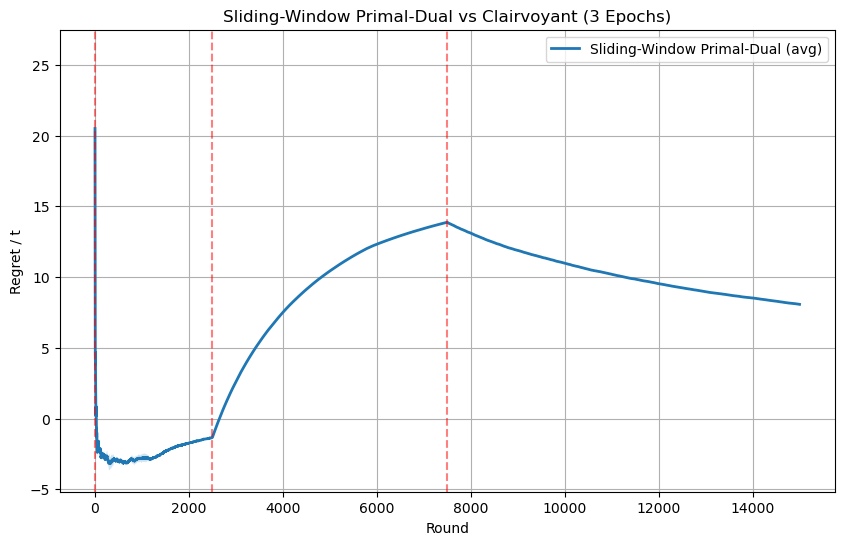

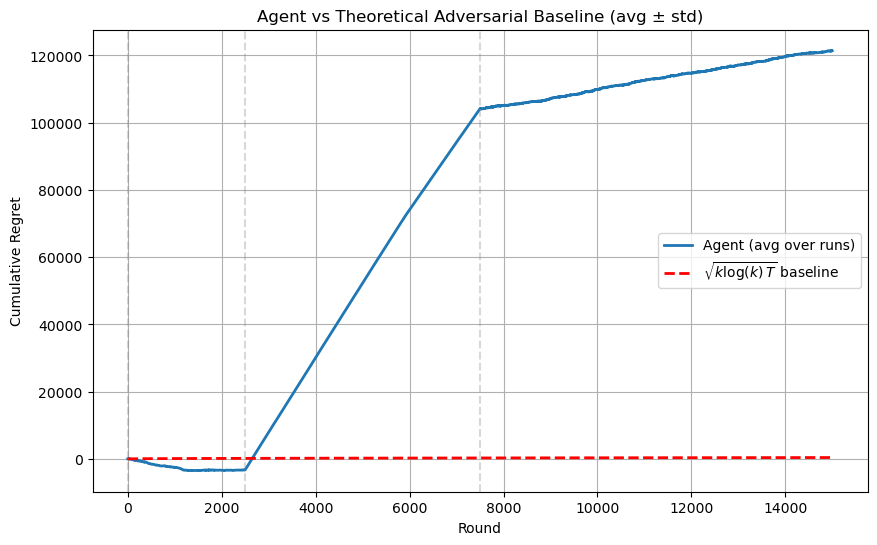

In [14]:
import numpy as np
import matplotlib.pyplot as plt

# --- 1) Sliding-Window Primal-Dual average regret ratio with std deviation ---
avg_regret_ratio = np.mean(all_regret_ratios, axis=0)
std_regret_ratio = np.std(all_regret_ratios, axis=0)

plt.figure(figsize=(10,6))
plt.plot(range(T_total), avg_regret_ratio, lw=2, label="Sliding-Window Primal-Dual (avg)")
plt.fill_between(range(T_total),
                 avg_regret_ratio - std_regret_ratio,
                 avg_regret_ratio + std_regret_ratio,
                 alpha=0.2)
for interval in intervals:
    plt.axvline(interval['start'], color='red', linestyle='--', alpha=0.5)
plt.xlabel("Round")
plt.ylabel("Regret / t")
plt.title("Sliding-Window Primal-Dual vs Clairvoyant (3 Epochs)")
plt.grid(True)
plt.legend()
plt.show()


# --- 2) Agent cumulative regret vs theoretical adversarial baseline with avg ± std ---
# Compute cumulative regret per run
cumulative_regrets_all = []
for run in range(n_runs):
    cumulative_regret_run = np.cumsum([clair_rewards[i] - agent_rewards[i] for i in range(T_total)])
    cumulative_regrets_all.append(cumulative_regret_run)

cumulative_regrets_all = np.array(cumulative_regrets_all)
avg_cum_regret = np.mean(cumulative_regrets_all, axis=0)
std_cum_regret = np.std(cumulative_regrets_all, axis=0)

# Theoretical adversarial baseline
k = max(1, N * P)
theoretical_regret = np.sqrt(k * np.log(max(2, k)) * np.arange(1, T_total + 1))

plt.figure(figsize=(10,6))
plt.plot(range(T_total), avg_cum_regret, lw=2, label="Agent (avg over runs)")
plt.fill_between(range(T_total),
                 avg_cum_regret - std_cum_regret,
                 avg_cum_regret + std_cum_regret,
                 alpha=0.2)
plt.plot(range(1, T_total + 1), theoretical_regret, 'r--', lw=2,
         label=r"$\sqrt{k \log(k) \, T}$ baseline")

for interval in intervals:
    plt.axvline(interval['start'], color='gray', linestyle='--', alpha=0.3)

plt.xlabel("Round")
plt.ylabel("Cumulative Regret")
plt.title("Agent vs Theoretical Adversarial Baseline (avg ± std)")
plt.grid(True)
plt.legend()
plt.show()


This plot shows the average cumulative regret per round of the `DualAgent` across multiple runs, with a shaded region representing one standard deviation.

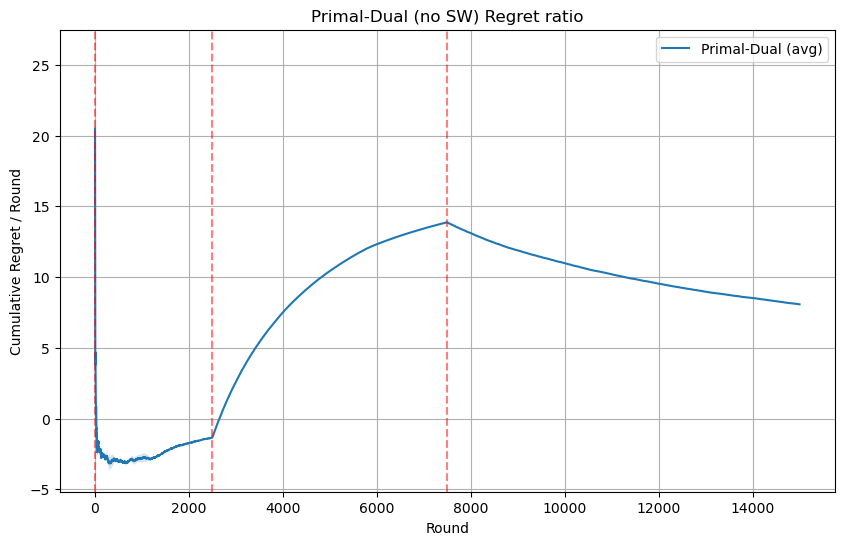

In [15]:
plt.figure(figsize=(10,6))
avg_regret = np.mean(all_regret_ratios, axis=0)
std_regret = np.std(all_regret_ratios, axis=0)
plt.plot(avg_regret, label="Primal-Dual (avg)")
plt.fill_between(range(T_total), avg_regret-std_regret, avg_regret+std_regret, alpha=0.2)
for interval in intervals:
    plt.axvline(interval['start'], color='red', linestyle='--', alpha=0.5)
plt.xlabel("Round")
plt.ylabel("Cumulative Regret / Round")
plt.title("Primal-Dual (no SW) Regret ratio")
plt.grid(True)
plt.legend()
plt.show()

In this simulation, we evaluate the performance of the `CombinatorialUCB` agent across a piecewise-stationary environment consisting of three epochs, each with its own expected reward structure and conversion probabilities. For each interval, we first compute the clairvoyant solution using a linear program, which acts as a benchmark by maximizing expected rewards with full knowledge of the environment. 

We then run multiple independent simulations (`n_runs`) where the agent interacts with the environment, pulls arms (chooses prices), observes demand and rewards, and updates its sliding-window estimates. At each round, we also sample the clairvoyant action to compute the per-round regret. The cumulative regret ratio is tracked over time for each run.

At the end, we compute the average regret ratio over all runs and visualize it across the total rounds. The red dashed lines in the plot indicate epoch transitions, showing how the agent adapts to changes in the environment while comparing against the clairvoyant benchmark.


In [16]:
# Run simulations
all_regret_ratios = []
final_regret_ratios = []

env = PricingEnvConversion(intervals=intervals, B=B, T=T_total, n_customers=n_customers)
agent = CombinatorialUCB(N=N, P=P, B=B, T=T_total, window_size=window_size)

clairvoyant_solutions = []

rho_clar = B / T_total

for interval in intervals:
    mu = np.array(interval['mu'])
    conversion_fn = interval['conversion_fn']

    # f: expected reward per product/price
    f = mu * np.array([conversion_fn(p) for p in range(P)]) * n_customers

    # c: expected cost per product/price
    c = np.array([[conversion_fn(p) for p in range(P)] for _ in range(N)]) * n_customers

    gamma_clar = agent.compute_opt(f, c, rho_clar)

    clairvoyant_solutions.append({
        "start": interval['start'],
        "end": interval['end'],
        "f": f,
        "c": c,
        "rho": rho_clar,
        "gamma": gamma_clar
    })


for seed in range(n_runs):
    np.random.seed(seed + 1)
    
    env = PricingEnvConversion(intervals=intervals, B=B, T=T_total, n_customers=n_customers)
    agent = CombinatorialUCB(N=N, P=P, B=B, T=T_total, window_size=window_size)
    agent.reset()  # ensure sliding windows are empty
    
    cumulative_regret = 0
    regret_ratio_per_round = []

    # Added for graphs later
    prices_per_round = []  # store agent prices per round
    agent_rewards = []      # reward obtained by agent each round
    clair_rewards = []      # reward obtained by clairvoyant each round
    agent_inventory_over_time = []


    for t in range(env.T):

        price_vector = agent.pull_arm()
        demand, profit = env.round(price_vector)
        total_reward = profit.sum()

        prices_per_round.append(price_vector.copy())

        # Update agent
        agent.update(price_vector, demand, profit)
        
        agent_inventory_over_time.append(agent.remaining_inventory)

        # Clairvoyant sample its action (via LP solution)
        interval_idx = env.current_interval
        clair_info = clairvoyant_solutions[interval_idx]
        gamma = clair_info["gamma"]
        f = clair_info["f"]

        # Sample clairvoyant action + reward for this round
        clair_action, clair_reward_per_round = clairvoyant_sample_action(gamma, f)

        agent_rewards.append(total_reward)
        clair_rewards.append(clair_reward_per_round)

        # Update cumulative regret
        cumulative_regret += clair_reward_per_round - total_reward
        regret_ratio_per_round.append(cumulative_regret / (t + 1))

        # Print checkpoint
        if t % checkpoint_interval == 0:
            print(f"Round {t}: Interval {interval_idx}")
            print(f"  Agent prices: {price_vector}, Reward: {total_reward:.2f}")
            print(f"  Clairvoyant prices: {clair_action}, Reward: {clair_reward_per_round:.2f}")
            print(f"  Cumulative regret / t: {cumulative_regret / (t + 1):.3f}\n")

    all_regret_ratios.append(regret_ratio_per_round)
    
    # Save final regret ratio for this run
    final_ratio = regret_ratio_per_round[-1]
    final_regret_ratios.append(final_ratio)
    print(f"Run {seed+1}/{n_runs} finished. Final regret ratio: {final_ratio:.4f}")


avg_regret_ratio = np.mean(all_regret_ratios, axis=0)
avg_final_regret_ratio = np.mean(final_regret_ratios)

# Summary print
print("\n=======================")
print("Summary of final regret ratios:")
for i, val in enumerate(final_regret_ratios, 1):
    print(f"  Run {i}: Final regret ratio = {val:.4f}")
print(f"  Average final regret ratio across runs = {avg_final_regret_ratio:.4f}")
print("=======================\n")



plt.figure(figsize=(10,6))
plt.plot(range(T_total), avg_regret_ratio, lw=1, label="Sliding-Window UCB (avg over runs)")

for interval in intervals:
    plt.axvline(interval['start'], color='red', linestyle='--', alpha=0.5)

plt.xlabel("Round")
plt.ylabel("Regret / t")
plt.title("Sliding-Window UCB vs Clairvoyant (3 Epochs)")
plt.grid(True)
plt.legend()
plt.show()


Round 0: Interval 0
  Agent prices: [0, 0], Reward: 3.00
  Clairvoyant prices: [-1, 2], Reward: 18.00
  Cumulative regret / t: 15.000

Round 1000: Interval 0
  Agent prices: [2, 2], Reward: 27.00
  Clairvoyant prices: [2, 2], Reward: 27.00
  Cumulative regret / t: -0.250

Round 2000: Interval 0
  Agent prices: [2, 2], Reward: 39.00
  Clairvoyant prices: [2, 2], Reward: 27.00
  Cumulative regret / t: 0.054

Round 3000: Interval 1
  Agent prices: [-1, 0], Reward: 36.00
  Clairvoyant prices: [-1, 0], Reward: 30.00
  Cumulative regret / t: 0.863



KeyboardInterrupt: 

Here we again plot the average cumulative regret over all runs, with a shaded area representing one standard deviation, to visualize the variability of the agent's performance across different simulations.


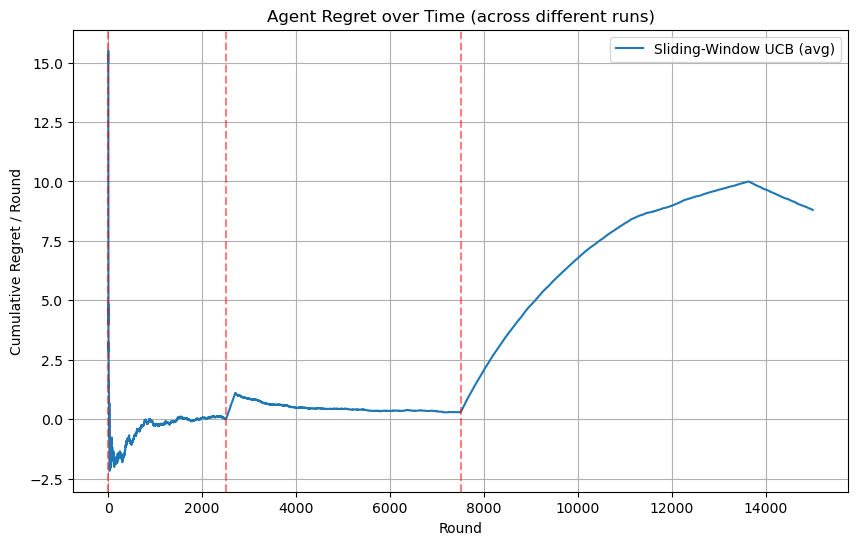

In [ ]:
plt.figure(figsize=(10,6))
avg_regret = np.mean(all_regret_ratios, axis=0)
std_regret = np.std(all_regret_ratios, axis=0)
plt.plot(avg_regret, label="Sliding-Window UCB (avg)")
plt.fill_between(range(T_total), avg_regret-std_regret, avg_regret+std_regret, alpha=0.2)
for interval in intervals:
    plt.axvline(interval['start'], color='red', linestyle='--', alpha=0.5)
plt.xlabel("Round")
plt.ylabel("Cumulative Regret / Round")
plt.title("Agent Regret over Time (across different runs)")
plt.grid(True)
plt.legend()
plt.show()

We plot the environment's consumption

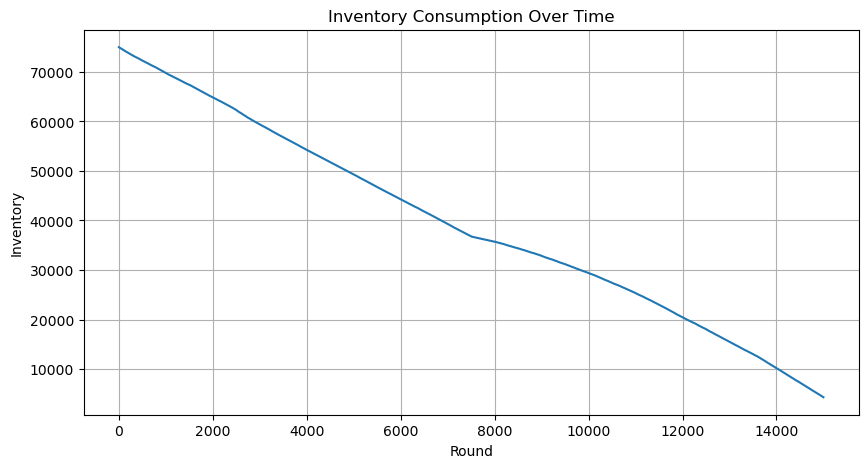

In [ ]:
plt.figure(figsize=(10,5))
plt.plot(agent_inventory_over_time, label="Remaining Inventory")
plt.xlabel("Round")
plt.ylabel("Inventory")
plt.title("Inventory Consumption Over Time")
plt.grid(True)
plt.show()

Here instead we visualize the specific prices chosen by the agent for each product at every round. Each row represents a product, each column a round, and the color indicates the selected price index. Black cells correspond to products that were not offered in that round.

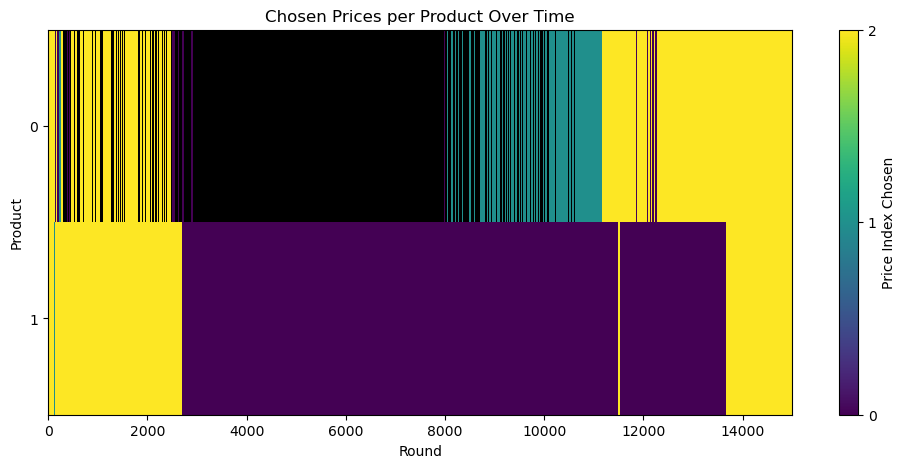

In [ ]:
import matplotlib.ticker as ticker
import numpy as np
import matplotlib.pyplot as plt

# Create a matrix: products × rounds
price_matrix = np.zeros((N, T_total))

for t in range(T_total):
    for i in range(N):
        price_matrix[i, t] = prices_per_round[t][i]  # -1 if not chosen

plt.figure(figsize=(12,5))

# Use a discrete colormap and set a specific color for -1
cmap = plt.cm.viridis
cmap.set_under(color='black')  # -1 will appear black

im = plt.imshow(price_matrix, aspect='auto', cmap=cmap, interpolation='nearest', vmin=0)

cbar = plt.colorbar(im)
cbar.set_label('Price Index Chosen')

cbar.set_ticks(np.arange(0, P))
cbar.set_ticklabels([str(i) for i in range(P)])

plt.xlabel("Round")
plt.ylabel("Product")
plt.yticks(np.arange(N))
plt.title("Chosen Prices per Product Over Time")
plt.show()


This figure shows boxplots of the rewards obtained by the agent and the clairvoyant in each epoch. It allows us to compare how the agent's performance varies across intervals relative to the clairvoyant benchmark, highlighting both median performance and variability.

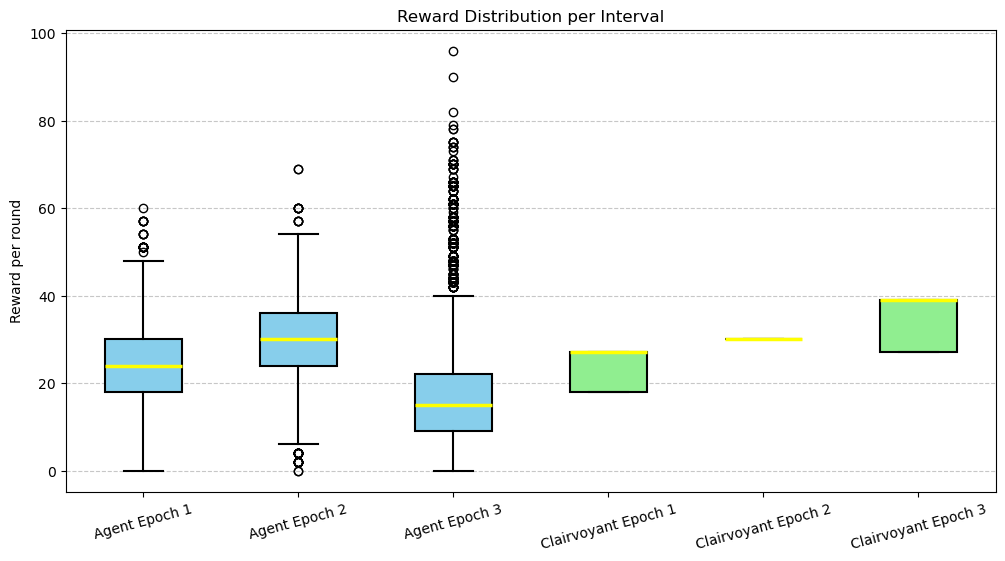

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

interval_bounds = [(int(interval['start']), int(interval['end'])) for interval in intervals]

agent_rewards_per_interval = [agent_rewards[t0:t1] for t0, t1 in interval_bounds]
clair_rewards_per_interval = [clair_rewards[t0:t1] for t0, t1 in interval_bounds]

all_boxes = agent_rewards_per_interval + clair_rewards_per_interval
labels = [f"Agent Epoch {i+1}" for i in range(len(intervals))] + \
         [f"Clairvoyant Epoch {i+1}" for i in range(len(intervals))]

plt.figure(figsize=(12,6))

boxprops = dict(linestyle='-', linewidth=1.5, color='black')
medianprops = dict(linestyle='-', linewidth=2.5, color='yellow')
whiskerprops = dict(linewidth=1.5, color='black')
capprops = dict(linewidth=1.5, color='black')

bplot = plt.boxplot(all_boxes, labels=labels, patch_artist=True,
                    boxprops=boxprops, medianprops=medianprops,
                    whiskerprops=whiskerprops, capprops=capprops)

colors = ['skyblue'] * len(agent_rewards_per_interval) + ['lightgreen'] * len(clair_rewards_per_interval)
for patch, color in zip(bplot['boxes'], colors):
    patch.set_facecolor(color)

plt.ylabel("Reward per round")
plt.title("Reward Distribution per Interval")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(rotation=15)
plt.show()
